# Nichnetr

GitHub: https://github.com/saeyslab/nichenetr  
Publication: https://www.nature.com/articles/s41592-019-0667-5

Omnipath 
GitHub https://github.com/saezlab/OmnipathR  
Vigniette https://workflows.omnipathdb.org/nichenet1.html  

The goal of this study, is to apply NicheNet to predict which ligands expressed by myeloid cells in the red pulp of the spleen are most likely to have induced the differential expression Erythroblast and its progenitors. 

In [1]:
library_load <- suppressMessages(
    
    list(
        # Seurat 
        library(Seurat), 
        
        # Nichnetr
        library(nichenetr), 
        
        # OmnipathR
        library(OmnipathR), 
        
        # Data 
        library(tidyverse)   
    )
)

In [2]:
# Set working directory to project root
setwd("/research/peer/fdeckert/FD20200109SPLENO")

In [3]:
# Source files
source("plotting_global.R")
source("bin/SeuratQC.R")

In [4]:
options(warn=-1)

# Parameter settings

In [5]:
# Seurat object
so_file <- "data/object/seurat_int.rds"

# Plotting Theme
ggplot2::theme_set(theme_global_set()) # From project global source()

# Import Seurat object

In [6]:
so <- readRDS(so_file)

# NichNet model, ligand-receptor network and weighted integrated networks 

In [7]:
# target genes in rows, ligands in columns
ligand_target_matrix <- readRDS(url("https://zenodo.org/record/3260758/files/ligand_target_matrix.rds"))

In [8]:
colnames(ligand_target_matrix) = ligand_target_matrix %>% colnames() %>% convert_human_to_mouse_symbols() 
rownames(ligand_target_matrix) = ligand_target_matrix %>% rownames() %>% convert_human_to_mouse_symbols() 

ligand_target_matrix = ligand_target_matrix %>% .[!is.na(rownames(ligand_target_matrix)), !is.na(colnames(ligand_target_matrix))]

In [9]:
lr_network <- readRDS(url("https://zenodo.org/record/3260758/files/lr_network.rds"))

In [10]:
lr_network$from =  convert_human_to_mouse_symbols(lr_network$from) 
lr_network$to =  convert_human_to_mouse_symbols(lr_network$to) 

lr_network = lr_network[!(is.na(lr_network$from)) | (is.na(lr_network$to)), ]

In [44]:
# weighted_networks$lr_sig: interactions and their weights in the ligand-receptor + signaling network
# weighted_networks$gr: interactions and their weights in the gene regulatory network
weighted_networks <- readRDS(url("https://zenodo.org/record/3260758/files/weighted_networks.rds"))
weighted_networks_lr <- weighted_networks$lr_sig 

weighted_networks_lr$from =  convert_human_to_mouse_symbols(weighted_networks_lr$from) 
weighted_networks_lr$to =  convert_human_to_mouse_symbols(weighted_networks_lr$to) 

weighted_networks_lr = weighted_networks_lr[!(is.na(weighted_networks_lr$from)) | (is.na(weighted_networks_lr$to)), ]

weighted_networks_lr <- inner_join(weighted_networks_lr, lr_network %>% distinct(from,to), by=c("from","to"))

# Create Seurat object with human gene IDs, RNA counts data slot and integrated Leiden cluster information 

In [13]:
cnt <- GetAssayData(so, assay="RNA", slot="counts")

so_hgnc <- CreateSeuratObject(cnt)
so_hgnc <- AddMetaData(so_hgnc, so@meta.data)
so_hgnc <- NormalizeData(so_hgnc)

so_hgnc$integrated_snn_res.0.8 <- as.numeric(so_hgnc$integrated_snn_res.0.8)
so_hgnc$integrated_snn_res.0.8 <- factor(so_hgnc$integrated_snn_res.0.8, levels = 1:length(unique(so_hgnc$integrated_snn_res.0.8)))
so_hgnc <- SetIdent(so_hgnc, value=so_hgnc[["integrated_snn_res.0.8"]])


so_nacl <- subset(so_hgnc, subset = treatment == "NaCl")
so_cpg <- subset(so_hgnc, subset = treatment == "CpG")
so <- so_hgnc

# Perform NicheNet analysis 

## Define receiver / sender cell and background population

In [14]:
# Receiver 
receiver <- 5
receiver_expressed_genes <- receiver %>% unique() %>% lapply(get_expressed_genes, so_cpg, 0.05)
receiver_expressed_genes <- receiver_expressed_genes %>% unlist() %>% unique()

In [15]:
# Sender
sender <- c(10, 13, 12, 11, 16, 21, 8, 6, 24, 14, 9)
sender_expressed_genes <- sender %>% unique() %>% lapply(get_expressed_genes, so_cpg, 0.05) # lapply to get the expressed genes of every sender cell type separately here
sender_expressed_genes <- sender_expressed_genes %>% unlist() %>% unique()

In [16]:
# Background 
background_expressed_genes <- receiver_expressed_genes %>% .[. %in% rownames(ligand_target_matrix)]

## Define a gene set of interest: these are the genes in the "receiver/target" cell population that are potentially affected by ligands expressed by interacting cells (e.g. genes differentially expressed upon cell-cell interaction)

I got good results with Erythroblast CpG vs cluster 10 NaCl

In [17]:
so_receiver <- merge(subset(so_cpg, idents=receiver), subset(so_nacl, idents=receiver))
so_receiver <- SetIdent(so_receiver, value=so_receiver[["treatment"]])

condition_oi <- "CpG"
condition_reference <- "NaCl" 

deg_receiver <- FindMarkers(object=so_receiver, ident.1=condition_oi, ident.2=condition_reference, logfc.threshold=0.1, min.pct=0.05, assay="RNA", test.use="MAST", verbose=FALSE) 
deg_receiver$cluster <- receiver
deg_receiver$gene <- rownames(deg_receiver)

geneset_oi <- deg_receiver %>% filter(p_val_adj <= 0.05 & abs(avg_log2FC) >= 0.1) %>% pull(gene)
geneset_oi <- geneset_oi %>% .[. %in% rownames(ligand_target_matrix)]


Done!

Combining coefficients and standard errors

Calculating log-fold changes

Calculating likelihood ratio tests

Refitting on reduced model...


Done!



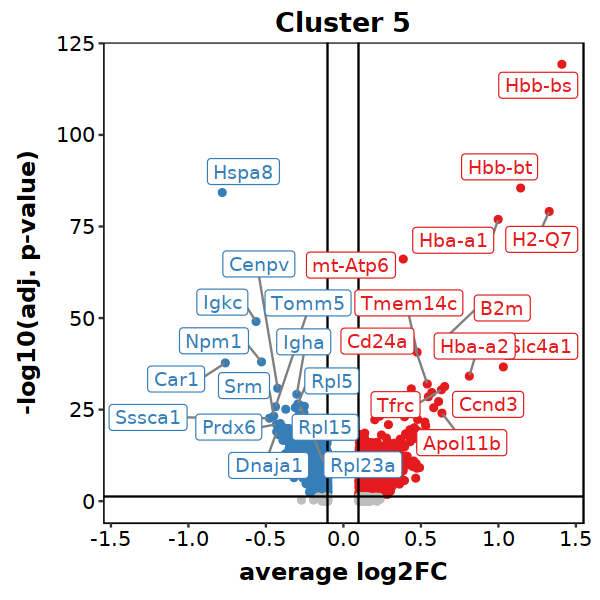

In [18]:
options(repr.plot.width=5, repr.plot.height=5)
source("bin/SeuratQC.R")
deg_volcano_plot_1 <- deg_volcano_plot(deg_receiver, log2_thold = 0.1, adjpvalue_thold = 0.05)
deg_volcano_plot_1

## Define a set of potential ligands: these are ligands that are expressed by the "sender/niche" cell population and bind a (putative) receptor expressed by the "receiver/target" population

In [19]:
ligands <- lr_network %>% pull(from) %>% unique()
receptors <- lr_network %>% pull(to) %>% unique()

expressed_ligands <- intersect(ligands, sender_expressed_genes)
expressed_receptors <- intersect(receptors, receiver_expressed_genes)

potential_ligands <- lr_network %>% filter(from %in% expressed_ligands & to %in% expressed_receptors) %>% pull(from) %>% unique()

## Perform NicheNet ligand activity analysis: rank the potential ligands based on the presence of their target genes in the gene set of interest (compared to the background set of genes) 

In [20]:
ligand_activities <- predict_ligand_activities(geneset=geneset_oi, background_expressed_genes=background_expressed_genes, ligand_target_matrix=ligand_target_matrix, potential_ligands=potential_ligands)
ligand_activities <- ligand_activities %>% arrange(-pearson) %>% mutate(rank=rank(desc(pearson)))

The different ligand activity measures (auroc, aupr, pearson correlation coefficient) are a measure for how well a ligand can predict the observed differentially expressed genes compared to the background of expressed genes. In the NichNet validation study, they showed that the pearson correlation coefficient between a ligand’s target predictions and the observed transcriptional response was the most informative measure to define ligand activity. Therefore, NicheNet ranks the ligands based on their pearson correlation coefficient. This allows to prioritize ligands inducing stress erythropoesis response in erythroblasts.

The number of top-ranked ligands that are further used to predict active target genes and construct an active ligand-receptor network is here 20.

In [21]:
best_upstream_ligands=ligand_activities %>% top_n(50, pearson) %>% arrange(-pearson) %>% pull(test_ligand) %>% unique()

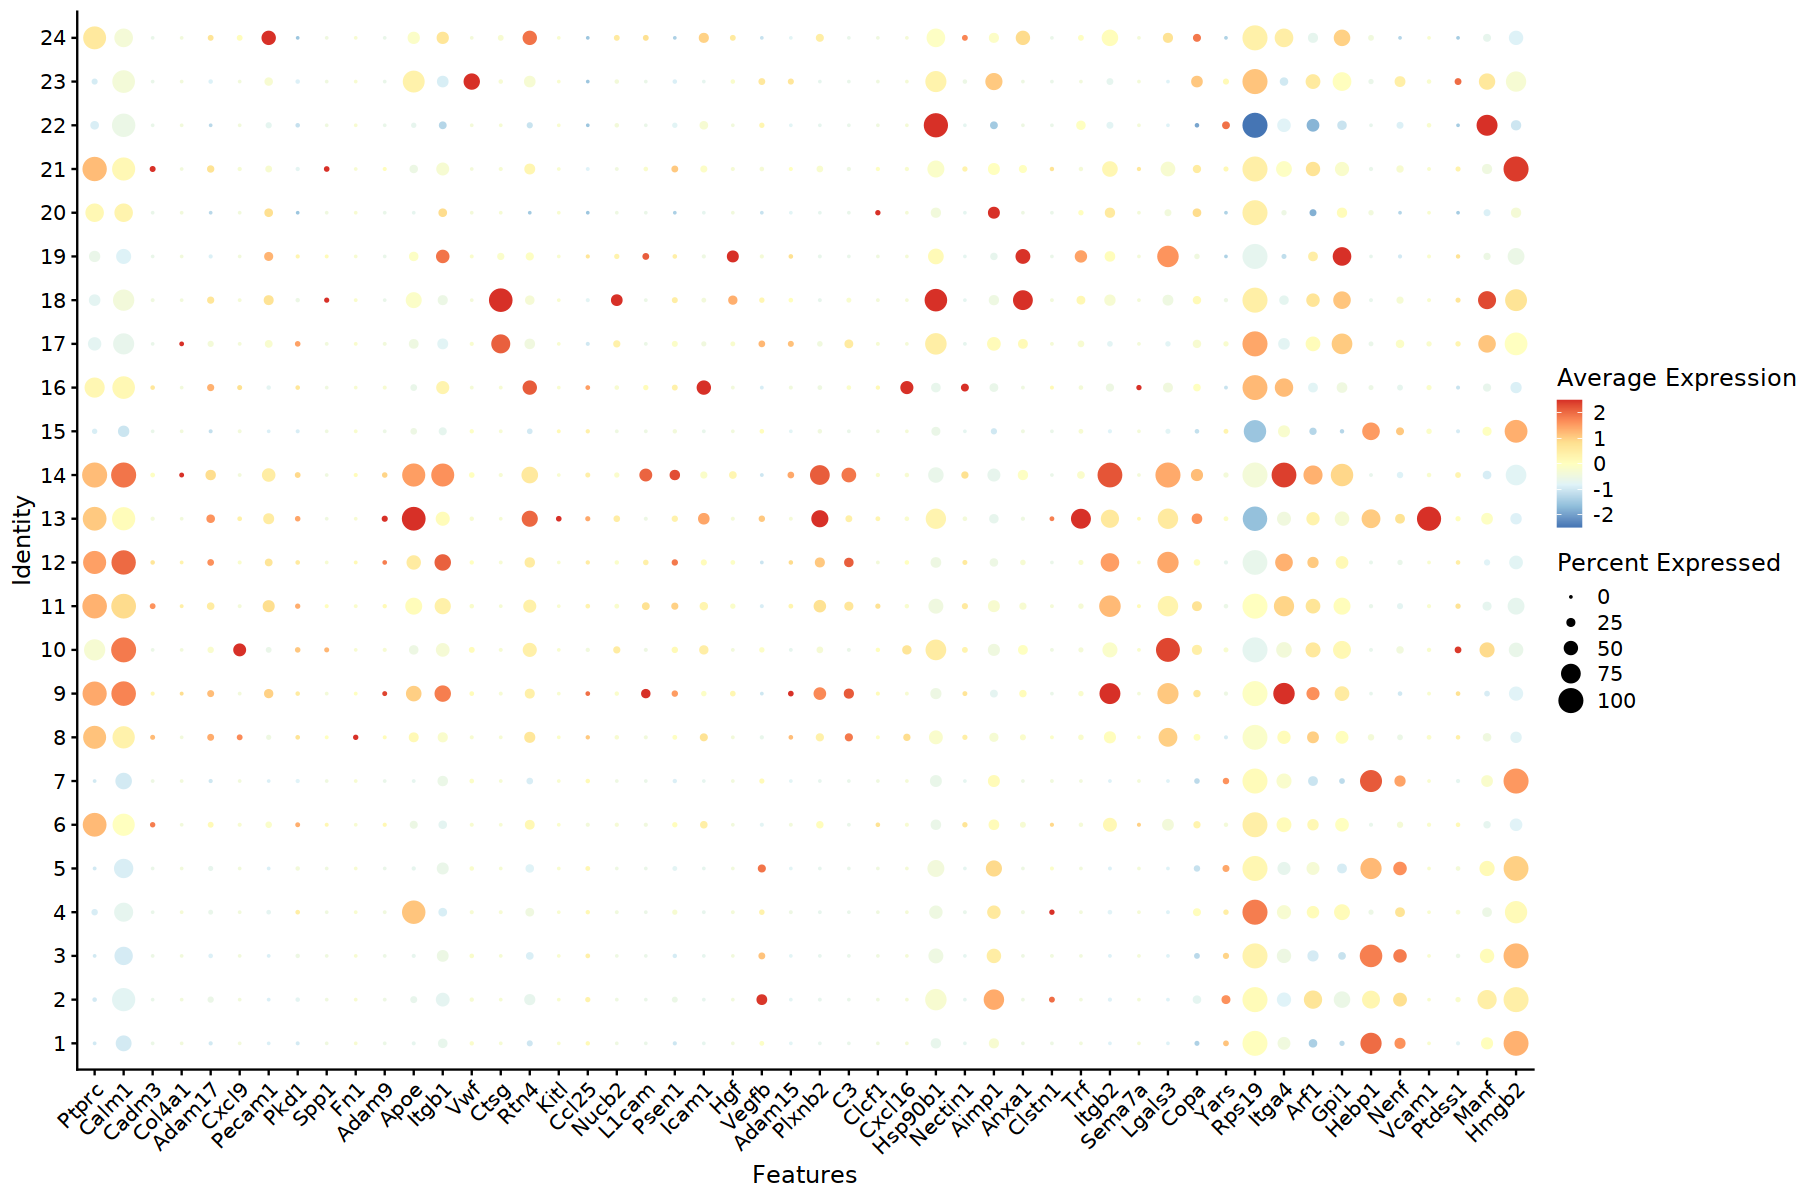

In [22]:
options(repr.plot.width=15, repr.plot.height=10)
dot_plot <- DotPlot(so_cpg, features=best_upstream_ligands %>% rev(), cols="RdYlBu") + RotatedAxis()
dot_plot
ggsave(dot_plot, filename="result/nichenet/plot/dot_plot.png", width=15, height=10)

## Infer receptors and top-predicted target genes of ligands that are top-ranked in the ligand activity analysis 

In [23]:
active_ligand_target_links_df=best_upstream_ligands %>% lapply(get_weighted_ligand_target_links,geneset=geneset_oi, ligand_target_matrix=ligand_target_matrix, n=200) %>% bind_rows() %>% drop_na()

active_ligand_target_links=prepare_ligand_target_visualization(ligand_target_df=active_ligand_target_links_df, ligand_target_matrix=ligand_target_matrix, cutoff=0.33)

order_ligands=intersect(best_upstream_ligands, colnames(active_ligand_target_links)) %>% rev() %>% make.names()
order_targets=active_ligand_target_links_df$target %>% unique() %>% intersect(rownames(active_ligand_target_links)) %>% make.names()
rownames(active_ligand_target_links)=rownames(active_ligand_target_links) %>% make.names() # make.names() for heatmap visualization of genes like H2-T23
colnames(active_ligand_target_links)=colnames(active_ligand_target_links) %>% make.names() # make.names() for heatmap visualization of genes like H2-T23

vis_ligand_target=active_ligand_target_links[order_targets,order_ligands] %>% t()

Scale for 'fill' is already present. Adding another scale for 'fill', which
will replace the existing scale.



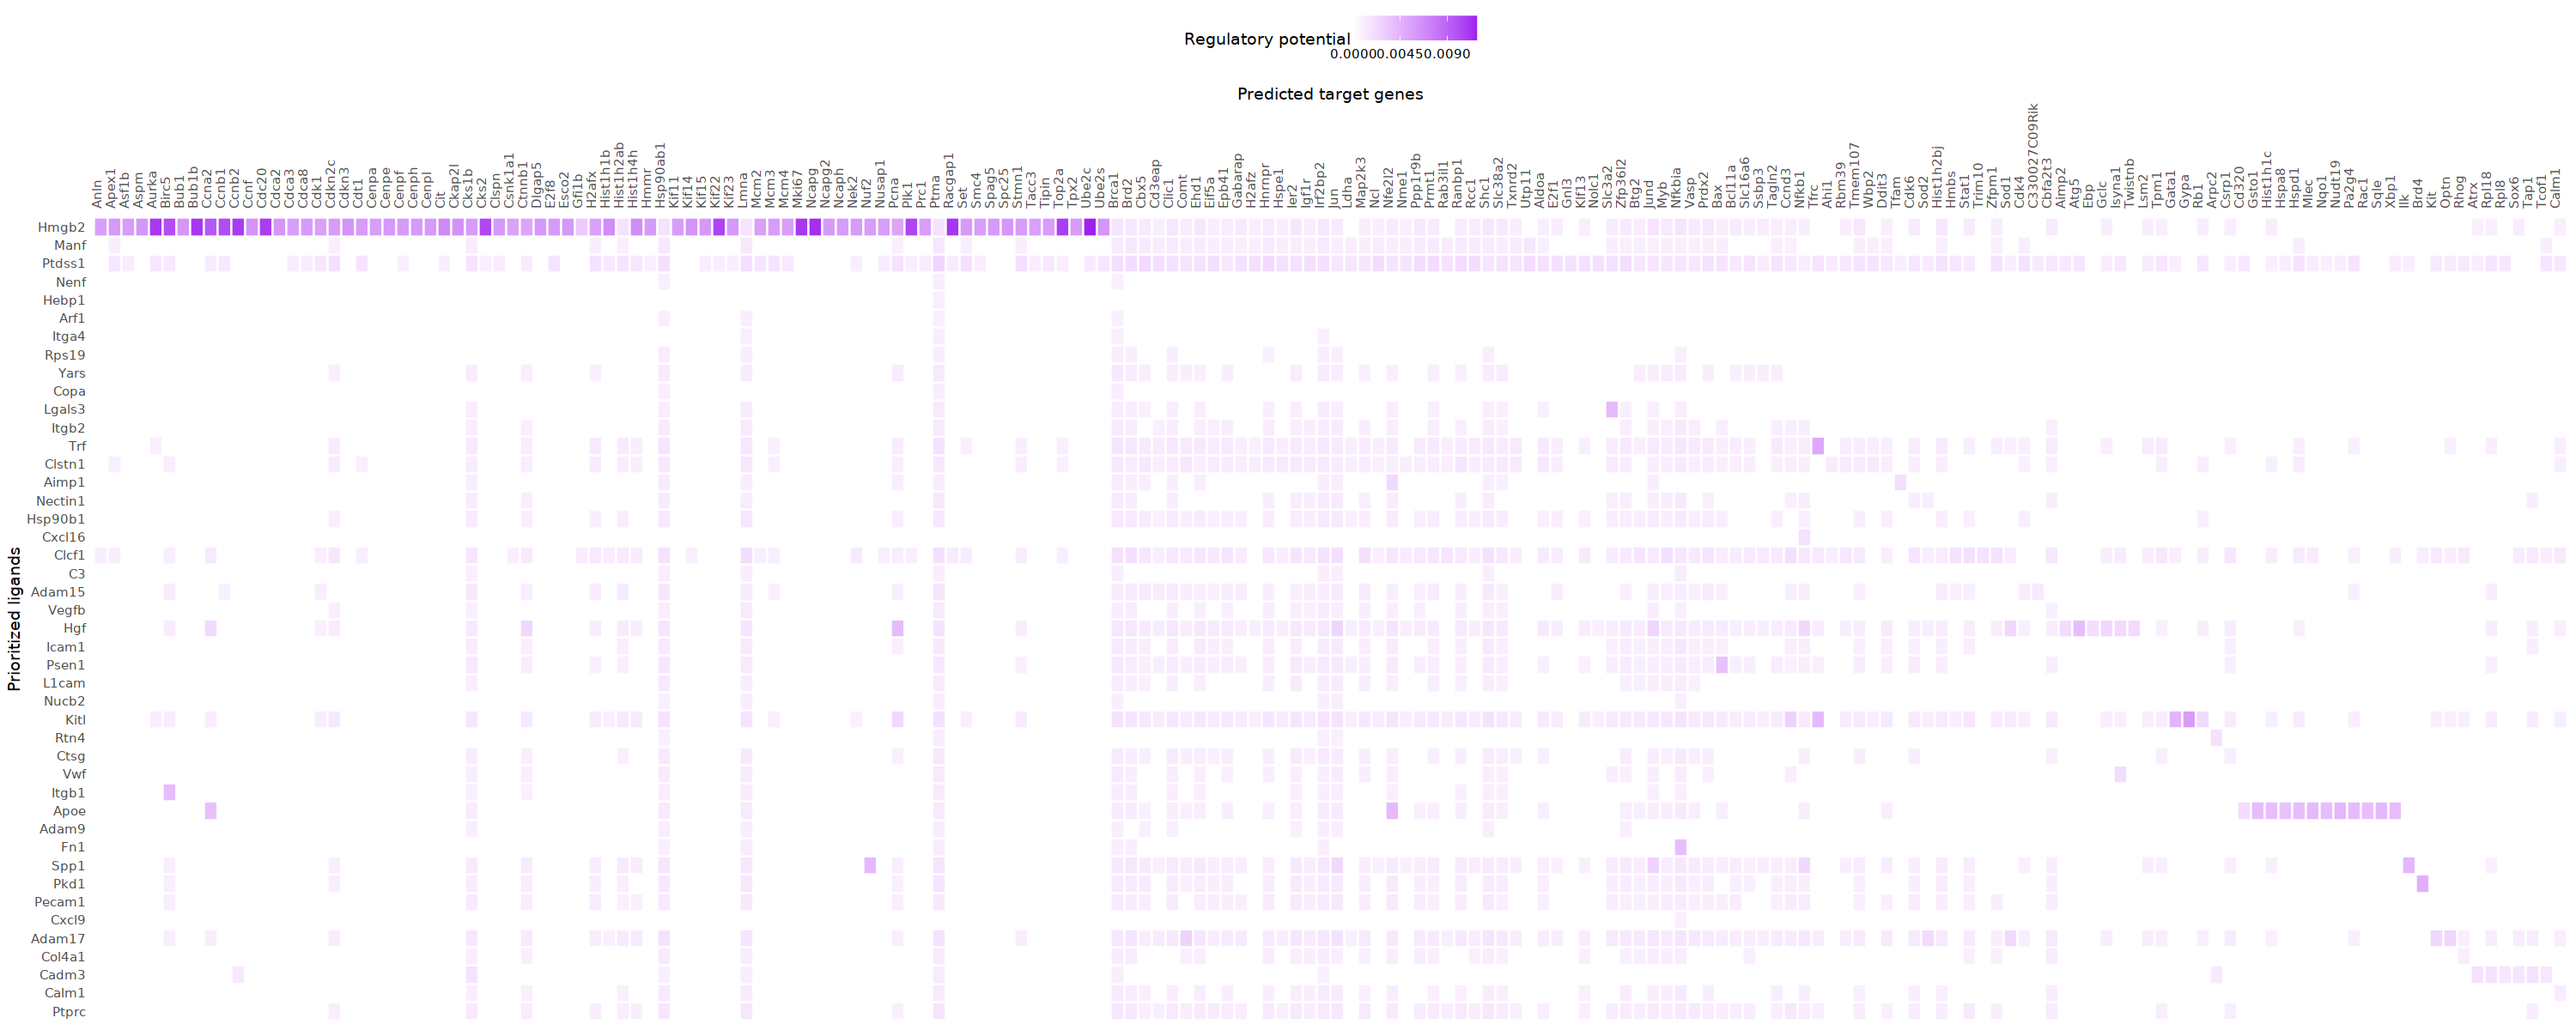

In [24]:
options(repr.plot.width=25, repr.plot.height=10)
p_ligand_target_network <- vis_ligand_target %>% make_heatmap_ggplot("Prioritized ligands","Predicted target genes", color="purple", legend_position="top", x_axis_position="top",legend_title="Regulatory potential") + theme(axis.text.x=element_text(face="italic")) + scale_fill_gradient2(low="whitesmoke",  high="purple", breaks=c(0,0.0045,0.0090))
p_ligand_target_network
ggsave(p_ligand_target_network, filename="result/nichenet/plot/p_ligand_target_network.png", width=25, height=10)

## Receptor of top-ranked ligands

In [45]:
lr_network_top = lr_network %>% filter(from %in% best_upstream_ligands & to %in% expressed_receptors) %>% distinct(from,to)
best_upstream_receptors = lr_network_top %>% pull(to) %>% unique()

lr_network_top_df_large = weighted_networks_lr %>% filter(from %in% best_upstream_ligands & to %in% best_upstream_receptors)

lr_network_top_df = lr_network_top_df_large %>% spread("from","weight", fill = 0)
lr_network_top_matrix = lr_network_top_df %>% dplyr::select(-to) %>% as.matrix() %>% magrittr::set_rownames(lr_network_top_df$to)

dist_receptors = dist(lr_network_top_matrix, method = "binary")
hclust_receptors = hclust(dist_receptors, method = "ward.D2")
order_receptors = hclust_receptors$labels[hclust_receptors$order]
    
dist_ligands = dist(lr_network_top_matrix %>% t(), method = "binary")
hclust_ligands = hclust(dist_ligands, method = "ward.D2")
order_ligands_receptor = hclust_ligands$labels[hclust_ligands$order]

order_receptors = order_receptors %>% intersect(rownames(lr_network_top_matrix))
order_ligands_receptor = order_ligands_receptor %>% intersect(colnames(lr_network_top_matrix))

vis_ligand_receptor_network = lr_network_top_matrix[order_receptors, order_ligands_receptor]
rownames(vis_ligand_receptor_network) = order_receptors %>% make.names()
colnames(vis_ligand_receptor_network) = order_ligands_receptor %>% make.names()

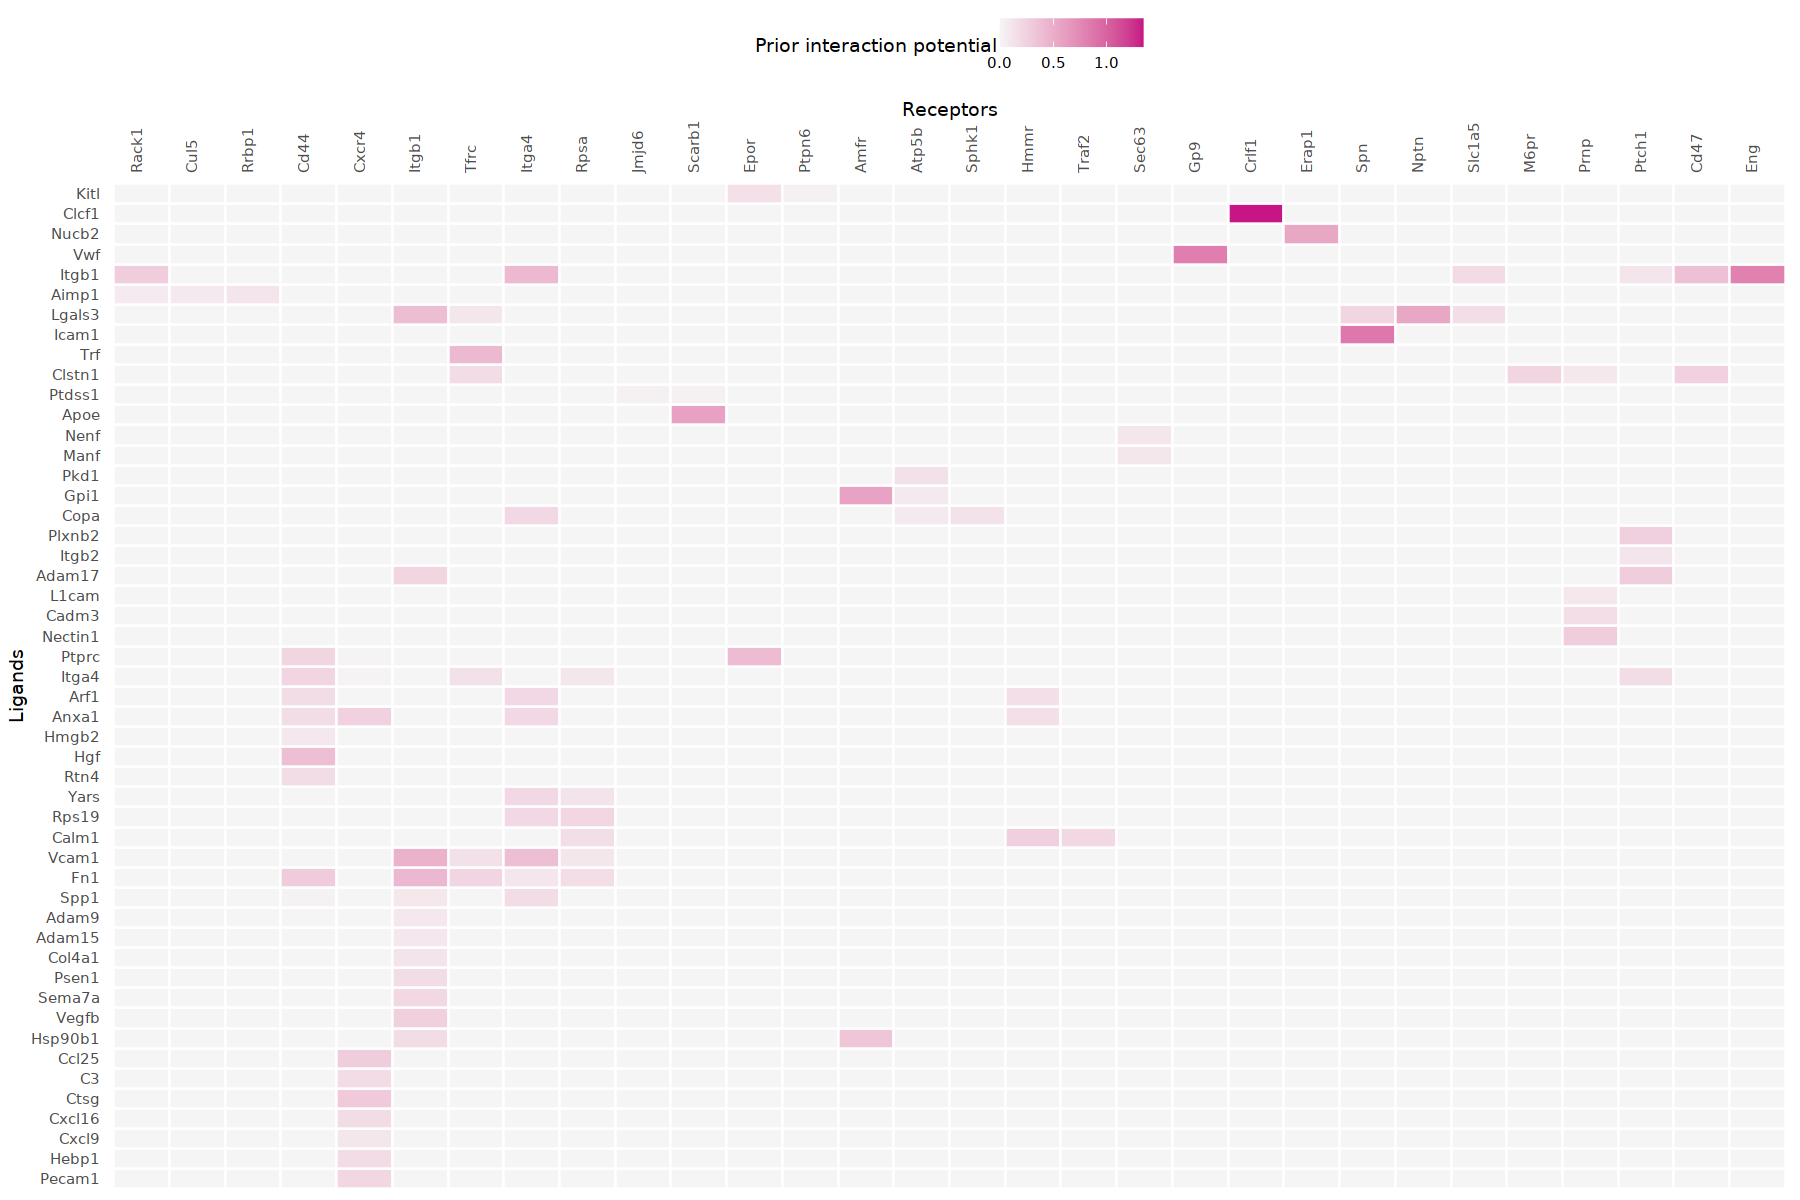

In [46]:
options(repr.plot.width=15, repr.plot.height=10)
p_ligand_receptor_network = vis_ligand_receptor_network %>% t() %>% make_heatmap_ggplot("Ligands","Receptors", color = "mediumvioletred", x_axis_position = "top",legend_title = "Prior interaction potential")
p_ligand_receptor_network
ggsave(p_ligand_receptor_network, filename="result/nichenet/plot/p_ligand_receptor_network.png", width=15, height=10)